# Build a time series model for either video CTR that predicts CTR values

## Author: Mia (Yuhsin) Hou

# Contents 

## 1. Data preprocessing 

## 2. Moving average

## 3. Exponential smoothing

## 4. Autoregressive model

## 5. ARIMA model

## 6. Conclusion - the best performing model

# Import necessary packages

In [747]:
#Builds 'n Installs
#!pip install scipy== 1.2
!pip install -q --upgrade scipy;
!pip install -q --upgrade statsmodels;

In [748]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
from pylab import rcParams

rcParams['figure.figsize'] = (20, 8)
sns.set_style('darkgrid')
plt.style.use('seaborn-darkgrid')

import warnings
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import io
import scipy
from datetime import datetime 
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates

# Part 1 - Data preprocessing 

## Load data

In [749]:
# Read data from Google Sheet
data_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSGSAElwKQxAuEtgxKcF7ieu8plG1IlGGJAWzdhucGapL_1uvHBO4_TySPVgcqvjA/pub?gid=147458028&single=true&output=csv"
ctr = pd.read_csv(data_path)
ctr.head(3)

,Date,Country,CTR
0,1/2/2019,United States,0.54%
1,1/3/2019,United States,0.51%
2,1/4/2019,United States,0.54%


In [750]:
ctr.tail(3)

,Date,Country,CTR
115,4/27/2019,United States,0.47%
116,4/28/2019,United States,0.46%
117,4/29/2019,United States,0.45%


From above dataset, we see that we are using 3 months of daily level dataset. 

In [751]:
ctr.dtypes

Date       object
Country    object
CTR        object
dtype: object

## Convert the date object to datetime format

In [752]:
ctr['Date'] = pd.to_datetime(ctr['Date'])

## Convert the CTR variable to float format

In [753]:
# Firstly convert it to string type.
ctr['CTR'].astype(str)

# Convert string to float.
ctr['CTR'] = ctr['CTR'].str.rstrip('%').astype('float') / 100.0
ctr[['CTR']]

,CTR
0,0.0054
1,0.0051
2,0.0054
3,0.0056
4,0.0059
...,...
113,0.0047
114,0.0045
115,0.0047
116,0.0046


## Visualize our data 

In [754]:
ctr_for_plot = ctr.set_index('Date')

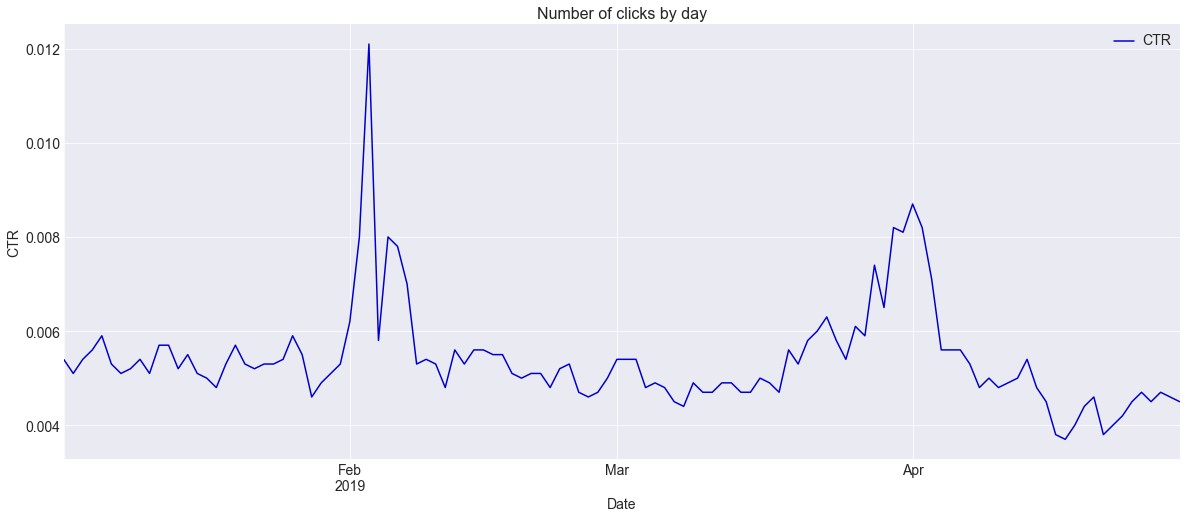

In [755]:
ax = ctr_for_plot.plot(figsize = (20, 8), color = 'mediumblue')
plt.ylabel('CTR', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.title('Number of clicks by day', fontsize = 16)

# Set the fontsize for x axis and y axis. 
ax.tick_params(axis = 'y', labelsize = 14)
ax.tick_params(axis = 'x', labelsize = 14)

# Set font size for legend text and title.
plt.setp(ax.get_legend().get_texts(), fontsize = '14') 

sns.despine()

# Part 2 - Moving average

## The moving averages of 7, 15, and 30 days respectively

In [756]:
ctr['MA_7'] = ctr['CTR'].rolling(7).mean()
ctr['MA_15'] = ctr['CTR'].rolling(15).mean()
ctr['MA_30'] = ctr['CTR'].rolling(30).mean()
ctr

,Date,Country,CTR,MA_7,MA_15,MA_30
0,2019-01-02,United States,0.0054,NaN,NaN,NaN
1,2019-01-03,United States,0.0051,NaN,NaN,NaN
2,2019-01-04,United States,0.0054,NaN,NaN,NaN
3,2019-01-05,United States,0.0056,NaN,NaN,NaN
4,2019-01-06,United States,0.0059,NaN,NaN,NaN
...,...,...,...,...,...,...
113,2019-04-25,United States,0.0047,0.00431,0.00442,0.00544
114,2019-04-26,United States,0.0045,0.00433,0.00439,0.00539
115,2019-04-27,United States,0.0047,0.00434,0.00437,0.00530
116,2019-04-28,United States,0.0046,0.00446,0.00432,0.00524


## Visualize the moving average result

Text(0, 0.5, 'CTR')

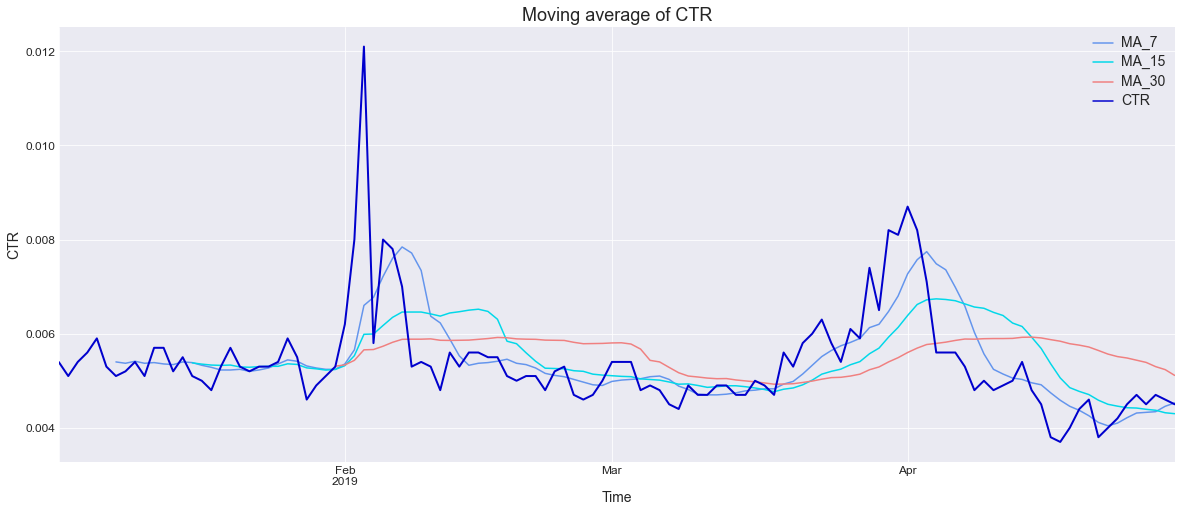

In [760]:
# Concatenate the columns of moving average. 
ma = pd.concat([ctr['MA_7'], ctr['MA_15'], ctr['MA_30'], ctr['CTR'], ctr['Date']], axis = 1).set_index('Date')
ax = ma.plot()

plt.gcf().set_size_inches(20, 8)

ma_7 = plt.gca().get_lines()[0].set_color('cornflowerblue')
ma_15 = plt.gca().get_lines()[1].set_color('#02d8e9')
ma_30 = plt.gca().get_lines()[2].set_color('lightcoral')
actual = plt.gca().get_lines()[3].set_color('mediumblue')

plt.gca().get_lines()[3].set_linewidth(2)

leg = ax.get_legend()

leg.legendHandles[0].set_color('cornflowerblue')
leg.legendHandles[1].set_color('#02d8e9')
leg.legendHandles[2].set_color('lightcoral')
leg.legendHandles[3].set_color('mediumblue')

# Set the title name and font size. 
ax.set_title('Moving average of CTR', fontsize = 18)

# Set the fontsize for x axis and y axis. 
ax.tick_params(axis = 'y', labelsize = 12)
ax.tick_params(axis = 'x', labelsize = 12)

# Set font size for legend text and title.
plt.setp(ax.get_legend().get_texts(), fontsize = '14') 
plt.setp(ax.get_legend().get_title(), fontsize = '14')

plt.xlabel('Time', fontsize = 14)
plt.ylabel('CTR', fontsize = 14)

## MSE for the moving averages of 7, 15, and 30 days respectively

MSE when moving average is 7 days:

In [559]:
# Create a new column with erroe^2 for MA_7
ctr['MA_7_error'] = pow(ctr['MA_7'] - ctr['CTR'], 2)

# Caculate the MSE
MSE_MA_7 = ctr['MA_7_error'][7:].mean()
MSE_MA_7

7.437323037323033e-07

MSE when moving average is 15 days:

In [560]:
# Create a new column with erroe^2 for MA_15
ctr['MA_15_error'] = pow(ctr['MA_15'] - ctr['CTR'], 2)

# Caculate the MSE
MSE_MA_15 = ctr['MA_15_error'][15:].mean()
MSE_MA_15

1.1644345199568495e-06

MSE when moving average is 30 days:

In [561]:
# Create a new column with erroe^2 for MA_30
ctr['MA_30_error'] = pow(ctr['MA_30'] - ctr['CTR'], 2)

# Caculate the MSE
MSE_MA_30 = ctr['MA_30_error'][30:].mean()
MSE_MA_30

1.7565553030303028e-06

# Part 3 - Exponential smoothing

## Define the exponential smoothing function

Set alpha with 0.2, 0.5, 0.8.

In [562]:
def exp_smooth(df, old_col, new_col, alpha):
    series = df[old_col].values
    result = [series[0]]
    for i in range(1, len(series)):
        result.append(alpha * series[i - 1] + (1 - alpha) * result[i - 1])
    df[new_col] = result

In [563]:
ctr

,Date,Country,CTR,MA_7,MA_15,MA_30,MA_7_error,MA_15_error,MA_30_error
0,2019-01-02,United States,0.0054,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,United States,0.0051,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-04,United States,0.0054,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-05,United States,0.0056,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-06,United States,0.0059,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
113,2019-04-25,United States,0.0047,0.00431,0.00442,0.00544,1.48776e-07,7.84000e-08,5.42678e-07
114,2019-04-26,United States,0.0045,0.00433,0.00439,0.00539,2.93878e-08,1.13778e-08,7.92100e-07
115,2019-04-27,United States,0.0047,0.00434,0.00437,0.00530,1.27551e-07,1.06711e-07,3.60000e-07
116,2019-04-28,United States,0.0046,0.00446,0.00432,0.00524,2.04082e-08,7.84000e-08,4.05344e-07


## Set alpha with 0.2, 0.5, 0.8

In [564]:
exp_smooth(ctr, 'CTR', 'Exp_CTR_0.2', 0.2)
exp_smooth(ctr, 'CTR', 'Exp_CTR_0.5', 0.5)
exp_smooth(ctr, 'CTR', 'Exp_CTR_0.8', 0.8)

In [565]:
ctr

,Date,Country,CTR,MA_7,MA_15,MA_30,MA_7_error,MA_15_error,MA_30_error,Exp_CTR_0.2,Exp_CTR_0.5,Exp_CTR_0.8
0,2019-01-02,United States,0.0054,NaN,NaN,NaN,NaN,NaN,NaN,0.00540,0.00540,0.00540
1,2019-01-03,United States,0.0051,NaN,NaN,NaN,NaN,NaN,NaN,0.00540,0.00540,0.00540
2,2019-01-04,United States,0.0054,NaN,NaN,NaN,NaN,NaN,NaN,0.00534,0.00525,0.00516
3,2019-01-05,United States,0.0056,NaN,NaN,NaN,NaN,NaN,NaN,0.00535,0.00532,0.00535
4,2019-01-06,United States,0.0059,NaN,NaN,NaN,NaN,NaN,NaN,0.00540,0.00546,0.00555
...,...,...,...,...,...,...,...,...,...,...,...,...
113,2019-04-25,United States,0.0047,0.00431,0.00442,0.00544,1.48776e-07,7.84000e-08,5.42678e-07,0.00432,0.00431,0.00443
114,2019-04-26,United States,0.0045,0.00433,0.00439,0.00539,2.93878e-08,1.13778e-08,7.92100e-07,0.00439,0.00451,0.00465
115,2019-04-27,United States,0.0047,0.00434,0.00437,0.00530,1.27551e-07,1.06711e-07,3.60000e-07,0.00441,0.00450,0.00453
116,2019-04-28,United States,0.0046,0.00446,0.00432,0.00524,2.04082e-08,7.84000e-08,4.05344e-07,0.00447,0.00460,0.00467


## Visualize the exponential smoothing 

In [566]:
def exponential_smoothing_for_plot(series, alpha):
    result = [series[0]] # first value is same as series
    for i in range(1, len(series)):
        result.append(alpha * series[i - 1] + (1 - alpha) * result[i - 1])
    return result

In [567]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
    """
    with plt.style.context('seaborn-darkgrid'):    
        plt.figure(figsize = (20, 8))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label = "Alpha {}".format(alpha))
        
        plt.plot(series.values, 'lightcoral', label = 'Actual', linewidth = 3)
        plt.legend(loc = 'best', fontsize = 12)
        plt.axis('tight')
        plt.title('Exponential smoothing for CTR', fontsize = 18)
        plt.grid(True)
        plt.yticks(fontsize = 12)
        plt.xticks(fontsize = 12)
        plt.xlabel('Days', fontsize = 14)
        plt.ylabel('CTR', fontsize = 14)

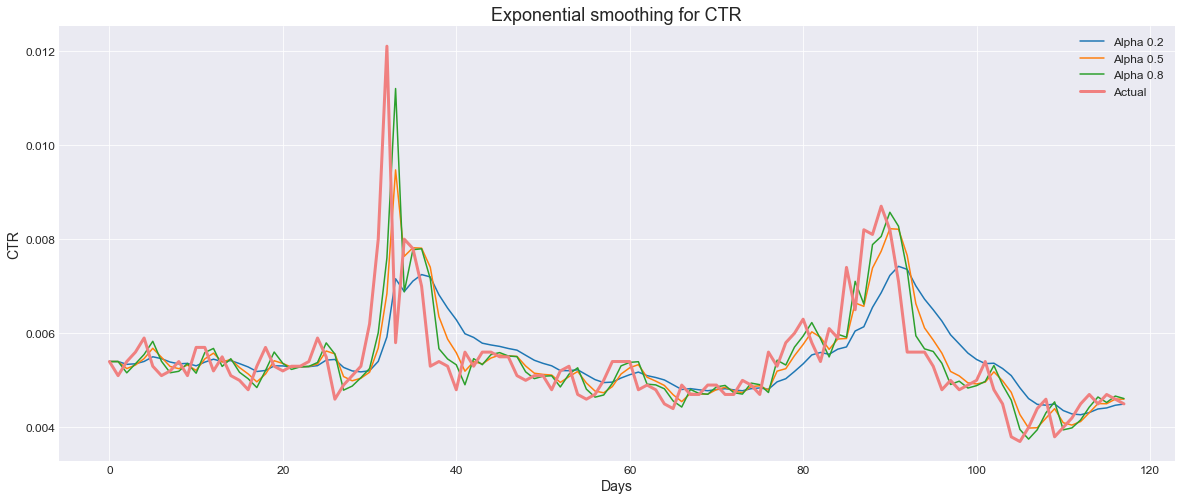

In [568]:
plotExponentialSmoothing(ctr.CTR, [0.2, 0.5, 0.8])

## Caculate the MSE with each alpha

MSE when the alpha is 0.2:

In [569]:
# Create a new column with erroe^2 for Exp_CTR_0.2
ctr['error_Exp_CTR_0.2'] = pow(ctr['Exp_CTR_0.2'] - ctr['CTR'], 2)

# Caculate the MSE
mse_exp_alpha_0Point2 = ctr['error_Exp_CTR_0.2'].mean()
mse_exp_alpha_0Point2

8.528267478322319e-07

MSE when the alpha is 0.5:

In [570]:
# Create a new column with erroe^2 for Exp_CTR_0.5
ctr['error_Exp_CTR_0.5'] = pow(ctr['Exp_CTR_0.5'] - ctr['CTR'], 2)

# Caculate the MSE
mse_exp_alpha_0Point5 = ctr['error_Exp_CTR_0.5'].mean()
mse_exp_alpha_0Point5

6.731777000877913e-07

MSE when the alpha is 0.8:

In [571]:
# Create a new column with erroe^2 for Exp_CTR_0.8
ctr['error_Exp_CTR_0.8'] = pow(ctr['Exp_CTR_0.8'] - ctr['CTR'], 2)

# Caculate the MSE
mse_exp_alpha_0Point8 = ctr['error_Exp_CTR_0.8'].mean()
mse_exp_alpha_0Point8

6.892343340572155e-07

# Part 4 - Autoregressive model

## Split training / testing dataset

Text(0.5, 1.0, 'Testing and training dataset for autoregressive model')

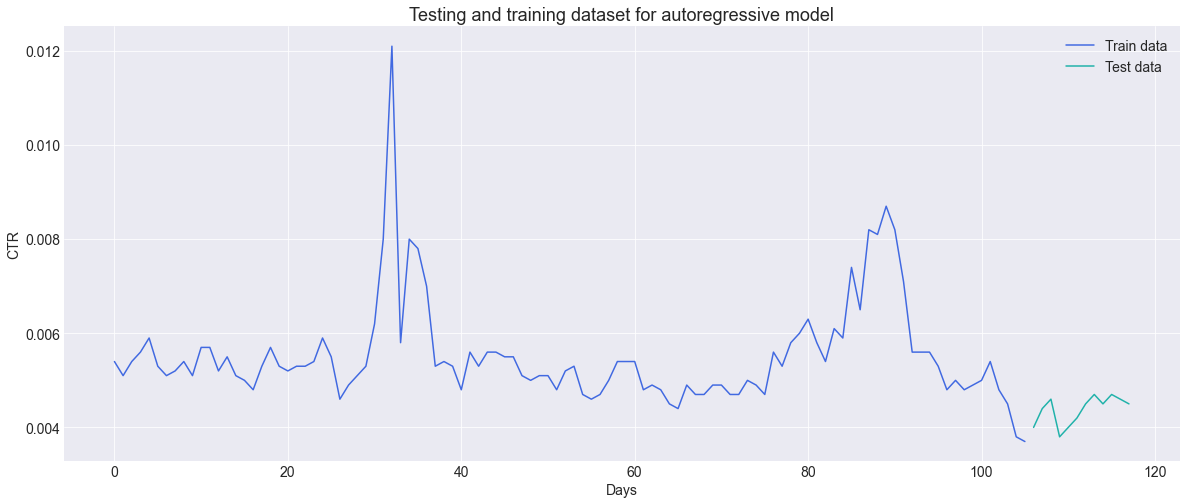

In [572]:
# Split training / testing dataset. 
cutoff = int(len(ctr) * 0.9)
train, test = ctr[0:cutoff], ctr[cutoff:]

plt.figure(figsize = (20, 8))
plt.grid(True)
plt.xlabel('Days', fontsize = 14)
plt.ylabel('CTR', fontsize = 14)
plt.plot(train['CTR'], 'royalblue', label = 'Train data')
plt.plot(test['CTR'], 'lightseagreen', label = 'Test data')
plt.legend(loc = 'best', fontsize = 14)

# Set the fontsize for x axis and y axis. 
plt.tick_params(axis = 'y', labelsize = 14)
plt.tick_params(axis = 'x', labelsize = 14)

plt.title('Testing and training dataset for autoregressive model', fontsize = 18)

## Autoregression model development and output

In [573]:
train_ar = train['CTR']
test_ar = test['CTR']

# Train autoregression
ar = AutoReg(train_ar, lags = 30)
ar_fit = ar.fit()
coef = ar_fit.params
print('Coefficients: %s' % coef)

Coefficients: intercept    5.13593e-03
CTR.L1       4.07590e-01
CTR.L2       3.21617e-01
CTR.L3       7.84554e-02
CTR.L4       4.36000e-02
CTR.L5      -2.48262e-01
CTR.L6      -1.36648e-01
CTR.L7       1.08097e-01
CTR.L8       4.00098e-03
CTR.L9       5.40991e-02
CTR.L10     -3.31796e-02
CTR.L11      9.07016e-06
CTR.L12      1.73043e-02
CTR.L13     -4.76137e-02
CTR.L14      1.60149e-03
CTR.L15     -1.25246e-01
CTR.L16     -8.15101e-02
CTR.L17      3.09159e-02
CTR.L18      5.25132e-03
CTR.L19     -4.34684e-02
CTR.L20     -6.90161e-02
CTR.L21      9.60303e-02
CTR.L22      5.27996e-03
CTR.L23     -1.16180e-01
CTR.L24     -9.00215e-02
CTR.L25     -7.79811e-02
CTR.L26      5.84077e-02
CTR.L27      1.43209e-01
CTR.L28      7.99898e-02
CTR.L29     -1.78641e-01
CTR.L30     -1.35264e-01
dtype: float64


## Make predictions

In [574]:
# Make predictions
predictions_ar = ar_fit.predict(start = len(train_ar), end = len(train_ar) + len(test_ar) - 1, dynamic = False)

# Create a comparison dataframe
compare_df = pd.concat([ctr['CTR'], predictions_ar], axis = 1).rename(columns = {'CTR': 'Actual', 0: 'Predicted'})
compare_df

,Actual,Predicted
0,0.0054,NaN
1,0.0051,NaN
2,0.0054,NaN
3,0.0056,NaN
4,0.0059,NaN
...,...,...
113,0.0047,0.00485
114,0.0045,0.00491
115,0.0047,0.00538
116,0.0046,0.00552


## Visualize the result

Text(0, 0.5, 'CTR')

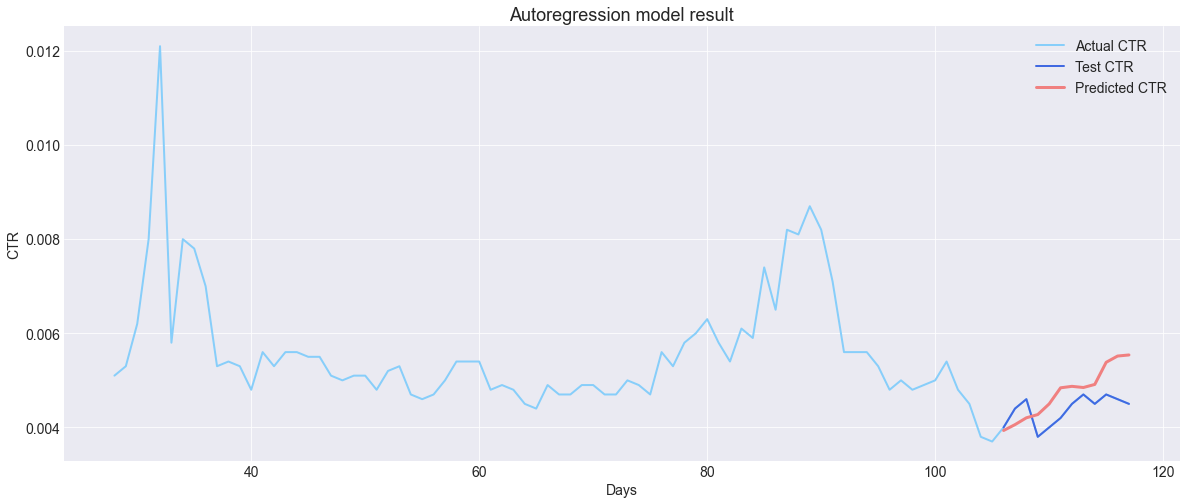

In [575]:
plt.figure(figsize = (20, 8))
plt.plot(ctr.index[-90:], ctr['CTR'].tail(90), color = 'lightskyblue', linewidth = 2, label = 'Actual CTR')
plt.plot(test_ar.index, test_ar, color = 'royalblue', linewidth = 2, label = 'Test CTR')
plt.plot(test_ar.index, predictions_ar, color = 'lightcoral', linewidth = 3, label = 'Predicted CTR')
plt.xticks(rotation = 0)
plt.grid(True)

plt.legend(loc = 'best', fontsize = 14)

# Set the fontsize for x axis and y axis. 
plt.tick_params(axis = 'y', labelsize = 14)
plt.tick_params(axis = 'x', labelsize = 14)

plt.title('Autoregression model result', fontsize = 18)
plt.xlabel('Days', fontsize = 14)
plt.ylabel('CTR', fontsize = 14)

## Caculate MSE

In [576]:
mse_ar = mean_squared_error(test_ar, predictions_ar)
mse_ar

3.2344451968161157e-07

# Part 5 - ARIMA model 

## ARIMA model development

In [577]:
arima_df = ctr['CTR']
train_arima = train['CTR']
test_arima = test['CTR']

history = [x for x in train_arima]
y = test_arima.values

# # Make first prediction
predictions_arima = list()
arima = ARIMA(history, order = (1, 1, 1))
arima_fit = arima.fit(disp = 0)
yhat = arima_fit.forecast()[0]
predictions_arima.append(yhat)
history.append(y[0])
# Rolling forecasts
for i in range(1, len(y)):
    # Predict
    arima = ARIMA(history, order = (1, 1, 1))
    arima_fit = arima.fit(disp = 0)
    yhat = arima_fit.forecast()[0]
    
    # Invert transformed prediction
    predictions_arima.append(yhat)
    # Observation
    obs = y[i]
    history.append(obs)

In [578]:
print(arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  116
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 659.526
Method:                       css-mle   S.D. of innovations              0.001
Date:                Sun, 14 Jun 2020   AIC                          -1311.051
Time:                        22:26:55   BIC                          -1300.037
Sample:                             1   HQIC                         -1306.580
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.181e-06   4.94e-05     -0.125      0.900      -0.000    9.06e-05
ar.L1.D.y     -0.1204      0.269     -0.448      0.654      -0.647       0.406
ma.L1.D.y     -0.2770      0.265     -1.045      0.2

## Caculate MSE

In [579]:
# Report performance
mse_arima = mean_squared_error(y, predictions_arima)
print('MSE: '+ str(mse_arima))

MSE: 1.0699369464517216e-07


## Visualize the result

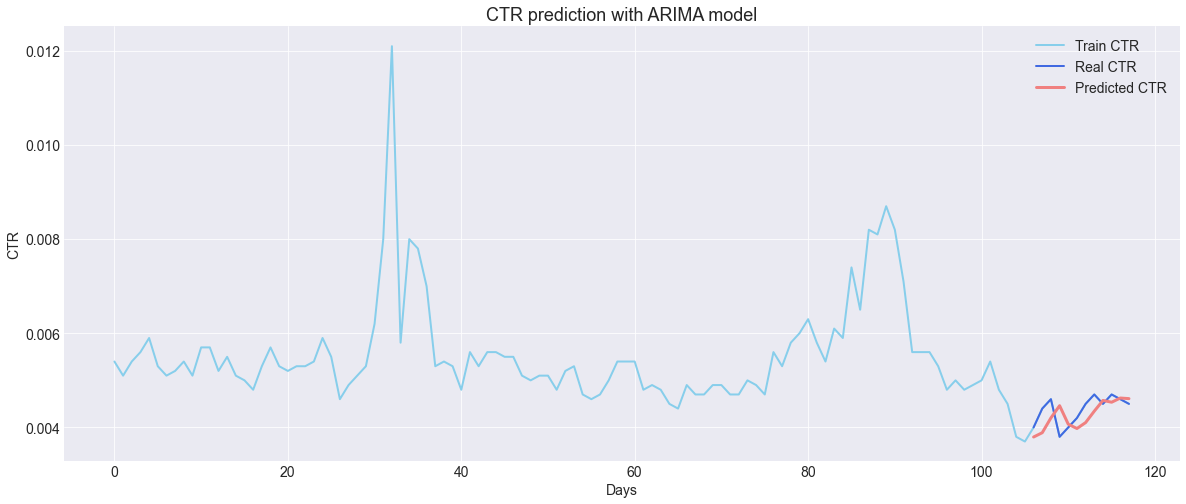

In [580]:
plt.figure(figsize = (20, 8))
plt.plot(ctr.index[-180:], ctr['CTR'].tail(180), color = 'skyblue', label = 'Train CTR', linewidth = 2)
plt.plot(test.index, y, color = 'royalblue', label = 'Real CTR', linewidth = 2)
plt.plot(test.index, predictions_arima, label = 'Predicted CTR', color = 'lightcoral', linewidth = 3)

plt.title('CTR prediction with ARIMA model', fontsize = 18)

plt.xlabel('Days',  fontsize = 14)
plt.ylabel('CTR',  fontsize = 14)

plt.legend(loc = 'best',  fontsize = 14)
plt.grid(True)

# Set the fontsize for x axis and y axis. 
plt.tick_params(axis = 'y', labelsize = 14)
plt.tick_params(axis = 'x', labelsize = 14)

# Part 6 - Conclusion 

## Evaluate the MSE performance on all models

In [581]:
mse_df = pd.DataFrame([['MA_7', MSE_MA_7],['MA_15', MSE_MA_15],['MA_30', MSE_MA_30],
                    ['Exp_alpha_0.2', mse_exp_alpha_0Point2], ['Exp_alpha_0.5', mse_exp_alpha_0Point5],
                   ['Exp_alpha_0.8', mse_exp_alpha_0Point8], ['Autoregressive', mse_ar], ['ARIMA', mse_arima]],
                   columns = ['Model','MSE'])
mse_df

,Model,MSE
0,MA_7,7.43732e-07
1,MA_15,1.16443e-06
2,MA_30,1.75656e-06
3,Exp_alpha_0.2,8.52827e-07
4,Exp_alpha_0.5,6.73178e-07
5,Exp_alpha_0.8,6.89234e-07
6,Autoregressive,3.23445e-07
7,ARIMA,1.06994e-07


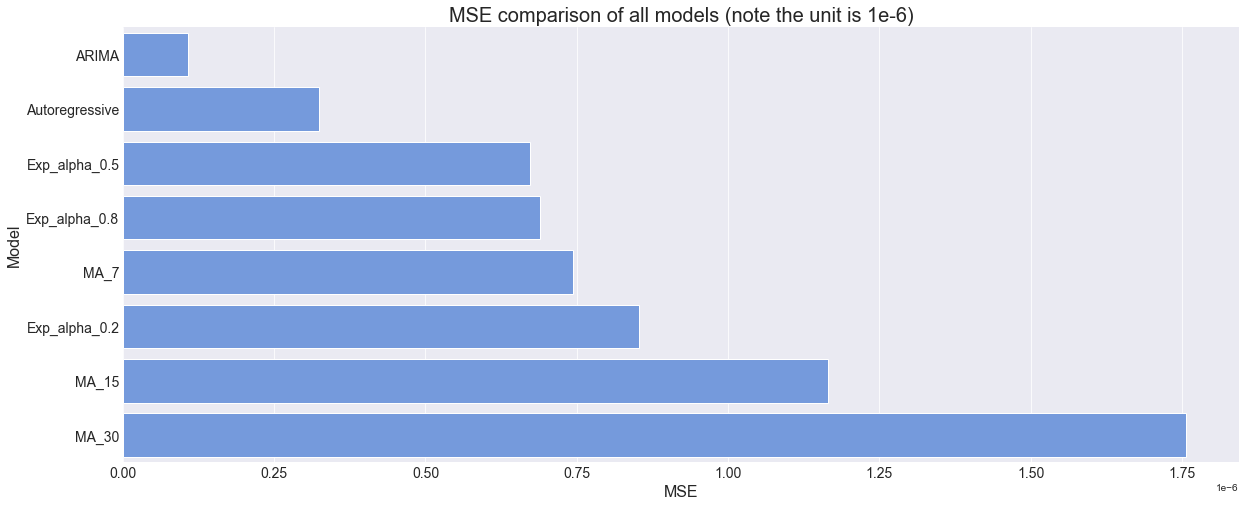

In [582]:
# Set figure size. 
rcParams['figure.figsize'] = (20, 8)

# Make barplot
ax = sns.barplot('MSE', 'Model', data = mse_df.sort_values(by = 'MSE'), 
                 color = 'cornflowerblue', orient = 'h')

# Set x_label, y_label, plot title name.  
ax.set_xlabel('MSE', fontsize = 16)
ax.set_ylabel('Model', fontsize = 16)
ax.set_title('MSE comparison of all models (note the unit is 1e-6)', fontsize = 20)

# Set the fontsize for x axis and y axis. 
ax.tick_params(axis = 'y', labelsize = 14)
ax.tick_params(axis = 'x', labelsize = 14)

The final result shows that MSE for ARIMA model is the lowest with 1.06994e-07. 

Therefore, ARIMA model is the best time series model to predict the CTR for either video CTR. 